In [1]:
import sys
sys.path.insert(0, "./")

from preference_data import *
from reward_model import *
import torch
import numpy as np
import matplotlib.pyplot as plt
from buildings_factory import *
import pickle

# buildings_list = ["ApartmentsThermal-v0", "ApartmentsGrid-v0", "Apartments2Thermal-v0",
#                   "Apartments2Grid-v0", "OfficesThermostat-v0", "MixedUseFanFCU-v0",
#                   "SeminarcenterThermostat-v0", "SeminarcenterFull-v0", "SimpleHouseRad-v0",
#                   "SimpleHouseRSla-v0", "SwissHouseRSlaW2W-v0", "SwissHouseRSlaTank-v0"] 


building_name = "SwissHouseRSlaW2W-v0"
min_kpis, max_kpis, min_outputs, max_outputs = collect_baseline_kpi(building_name)
building_idx = buildings_list.index(building_name)
env = get_env(building_name)
inputs = get_inputs(building_name, env)
default_control = default_controls[building_idx]
env_rl = StableBaselinesRLWrapper(building_name, min_kpis, max_kpis, min_outputs, max_outputs, reward_func, eval=True)
input_dim = env_rl.observation_space.shape[0]

# reward_model_loc = "data/models/{}/reward_model/reward_model_best_{}.pkl"
# reward_models = []
# for i in range(ensemble_num):
#     reward_model = RewardNet(input_dim)
#     _reward_model_loc = reward_model_loc.format(building_name, i)
#     reward_model.load_state_dict(torch.load(_reward_model_loc))
#     reward_model.eval()
#     reward_models.append(reward_model)
# reward_function = lambda min_kpi, max_kpi, kpi, state: learnt_reward_func(reward_models, min_kpi, max_kpi, kpi, state)

print(env_rl.output_specs)


cuda:0
the initial variables are {'u': 0}
[OK] <JMIRuntime><value name="build_date">"Feb 24 2021"</value> <value name="build_time">"21:25:41"</value></JMIRuntime>
[WARNING] <ModelicaMessage category="warning"><value name="msg">"... loading ""tab1"" from ""/home/lesong/Energym_runs/1670940151_5271322/resources/0/weather.mos""&##10;"</value></ModelicaMessage>
the initial variables are {'u': 0}
the initial variables are {'u': 0}
[OK] <JMIRuntime><value name="build_date">"Feb 24 2021"</value> <value name="build_time">"21:25:41"</value></JMIRuntime>
[WARNING] <ModelicaMessage category="warning"><value name="msg">"... loading ""tab1"" from ""/home/lesong/Energym_runs/1670940198_2402704/resources/0/weather.mos""&##10;"</value></ModelicaMessage>
{'weaBus.HDifHor': {'type': 'scalar', 'lower_bound': 0, 'upper_bound': 1000, 'description': 'Horizontal diffuse solar radiation (W/m2).'}, 'weaBus.HDirNor': {'type': 'scalar', 'lower_bound': 0, 'upper_bound': 1000, 'description': 'Direct normal radiati

In [15]:
from stable_baselines3 import PPO, SAC
building_name = "SwissHouseRSlaW2W-v0"
import pickle

round = 2
with open(f'data/offline_data/{building_name}/traj_data/{round}.pkl', 'rb') as f:
    trajectories = pickle.load(f)

def sample_trajectory(env, building_name, controller=None):
    building_idx = buildings_list.index(building_name)
    done = False
    state = env.reset()
    step = 0
    trajectory = [state]
    rule_controller = controller_list[building_idx]

    # trajectory.append(state)
    while step <= 288*2:
        # if controller is None: 
        control = env.unwrapped.sample_random_action()
        random_actions = env.transform_action(control)
        if controller is not None:
            actions, _ = controller.predict(state, deterministic=True)
            # _,hour,_,_ = env.unwrapped.get_date()
            # outputs = env.inverse_transform_state(state)
            # control = rule_controller(env.action_keys, step)(outputs, control_values[building_idx], hour)
            # rule_actions = env.transform_action(control)
            noisy_delta = 0.0
            actions = [noisy_delta*ra+(1.0-noisy_delta)*a for ra,a in zip(random_actions, actions)]
        else: actions = random_actions
        print("action: ", actions)
        state, reward, done, info = env.step(actions)
        kpis = env.unwrapped.get_kpi(start_ind=step, end_ind=step+1)
        trajectory.extend([actions, reward, kpis, state])
        # print("control: ", control, "outputs: ", env.outputs)
        # print("state: ", state, " ori:", env.inverse_transform_state(state))
        step += 1
    return trajectory
# model = SAC('MlpPolicy', env_rl, device='auto')
model_loc = f"data/models/{building_name}/manual_simulator_seed7/best_model/best_model.zip"
# # model_loc = f"data/models/{building_name}/manual_simulator_seed7/rl_model_204800_steps.zip"
# model.load(model_loc)
model = SAC.load(model_loc)
# out_df = pd.read_csv("data/models/SwissHouseRSlaW2W-v0/manual_simulator_seed7/logs/best/out.csv")
# for i, row in out_df.iterrows():
#     if i >= 288*2: break
#     outputs = {col:row[col] for col in out_df.columns}
#     state = env_rl.transform_state(outputs)
#     actions, _ = model.predict(state, deterministic=True)
#     print("action: ", env_rl.inverse_transform_action(actions))
    
# trajectory = sample_trajectory(env_rl, building_name, controller=model)
trajectory = trajectories[0]
# env_rl.step(env_rl.transform_action(env_rl.env.sample_random_action()))

traj_len = 288*1
for i in range(traj_len):
    state, action, old_reward, kpis, next_state = trajectory[4*i], trajectory[4*i+1], trajectory[4*i+2], trajectory[4*i+3], trajectory[4*i+4]
    print("ori action: ", action)
    print("model action: ", model.predict(state, deterministic=True))

ori action:  [0.19566559195518496]
model action:  (array([0.1224668], dtype=float32), None)
ori action:  [0.09876895025372505]
model action:  (array([0.10334182], dtype=float32), None)
ori action:  [0.18433492183685302]
model action:  (array([0.11005181], dtype=float32), None)
ori action:  [0.1377718836069107]
model action:  (array([0.10434389], dtype=float32), None)
ori action:  [0.13155643045902252]
model action:  (array([0.10781202], dtype=float32), None)
ori action:  [0.1681385636329651]
model action:  (array([0.10877097], dtype=float32), None)
ori action:  [0.16712258458137513]
model action:  (array([0.10612255], dtype=float32), None)
ori action:  [0.18196886777877808]
model action:  (array([0.10661876], dtype=float32), None)
ori action:  [0.1341261774301529]
model action:  (array([0.10572204], dtype=float32), None)
ori action:  [0.19496553838253022]
model action:  (array([0.11036965], dtype=float32), None)
ori action:  [0.17623060941696167]
model action:  (array([0.10553896], dty

In [3]:
new_traj_reward_list = []
old_traj_reward_list = []
controller = controller_list[building_idx]
out_list = []
cmd_list = []
traj_len = 288*10
for i in range(traj_len):
    state, action, old_reward, kpis, next_state = trajectory[4*i], trajectory[4*i+1], trajectory[4*i+2], trajectory[4*i+3], trajectory[4*i+4]
    # old_reward = reward_func(min_kpis, max_kpis, kpis)
    # print(old_reward, kpis)
    # print('next_state: ', next_state)
    # print("action: ", action)
    # print("ori next_state: ", env_rl.inverse_transform_state(next_state))
    old_traj_reward_list.append(old_reward)
    with torch.no_grad():
        # tran = np.concatenate((state, action, next_state))
        # model_in = torch.from_numpy(np.array(next_state)).reshape(1, -1).to(torch.float)
        new_reward = reward_function(min_kpis, max_kpis, kpis, next_state)
        new_traj_reward_list.append(new_reward)
    out_list.append(env_rl.inverse_transform_state(next_state))
    cmd_list.append(env_rl.inverse_transform_action(action))
out_df = pd.DataFrame(out_list)
cmd_df = pd.DataFrame(cmd_list)
plt.figure(figsize=(15, 8))
x = list(range(len(old_traj_reward_list)))
plt.plot(x, old_traj_reward_list, 'r--', x, new_traj_reward_list, 'b--')
# plt.plot(new_traj_reward_list, 'b--')
plt.show()
print(np.corrcoef(old_traj_reward_list, new_traj_reward_list))

NameError: name 'reward_function' is not defined

NameError: name 'out_df' is not defined

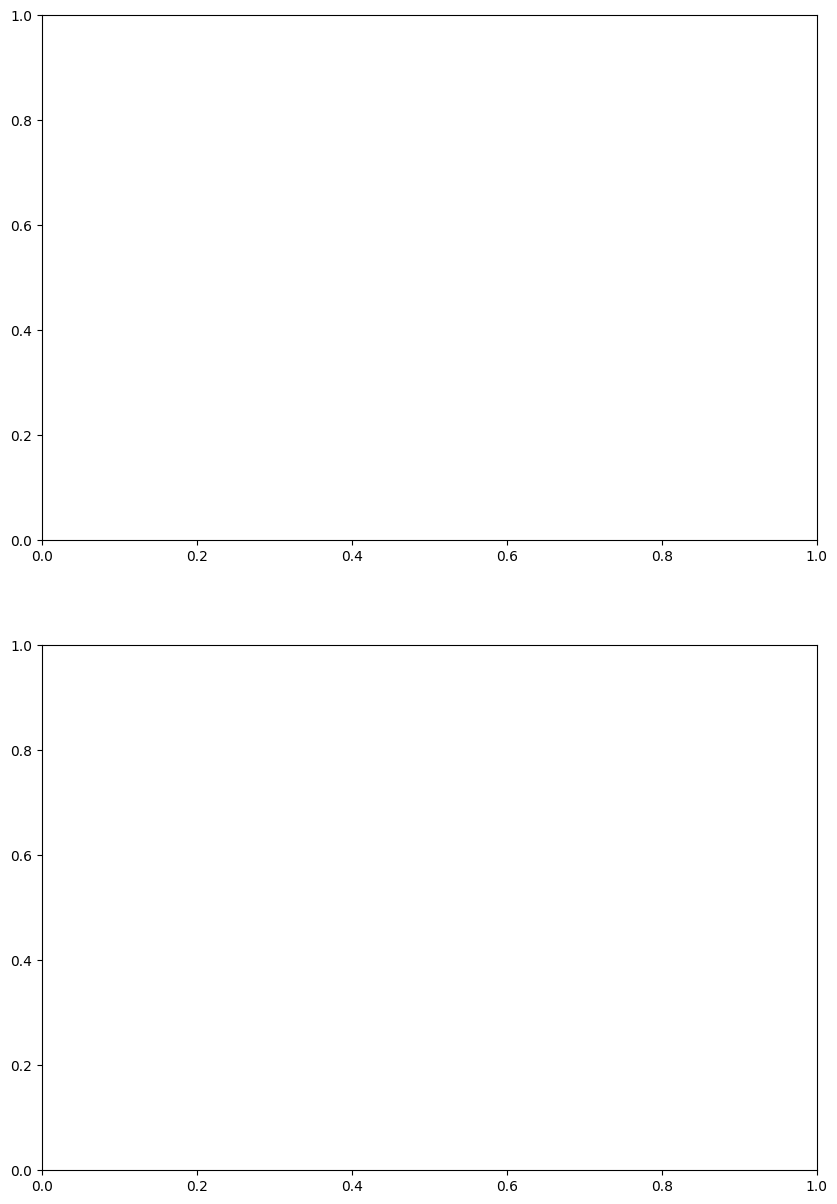

In [4]:
kpi_targets = {}
all_cols_plot = []
for key, val in env_rl.env.kpis.kpi_options.items():
    if "target" in val: kpi_targets[val["name"]] = val["target"]
    if val["name"] not in all_cols_plot: all_cols_plot.append(val["name"])
    
# plot key values
f, axs = plt.subplots(len(all_cols_plot),figsize=(10,15))#
for i, col in enumerate(all_cols_plot):
    axs[i].plot(out_df[col], 'r')
    axs[i].set_ylabel(col)
    axs[i].set_xlabel('Steps')
    if col in kpi_targets: intervals = (kpi_targets[col] if isinstance(kpi_targets[col], list) else [kpi_targets[col], kpi_targets[col]])
    elif env_rl.env.output_specs[col]["type"] == "scalar": intervals = [env_rl.env.output_specs[col]['lower_bound'], env_rl.env.output_specs[col]['upper_bound']]
    else: intervals = [0, 0]
    axs[i].plot([0, out_df.shape[0]], [intervals[0], intervals[0]], color='g', linestyle='--', linewidth=2)
    axs[i].plot([0, out_df.shape[0]], [intervals[1], intervals[1]], color='g', linestyle='--', linewidth=2)
    

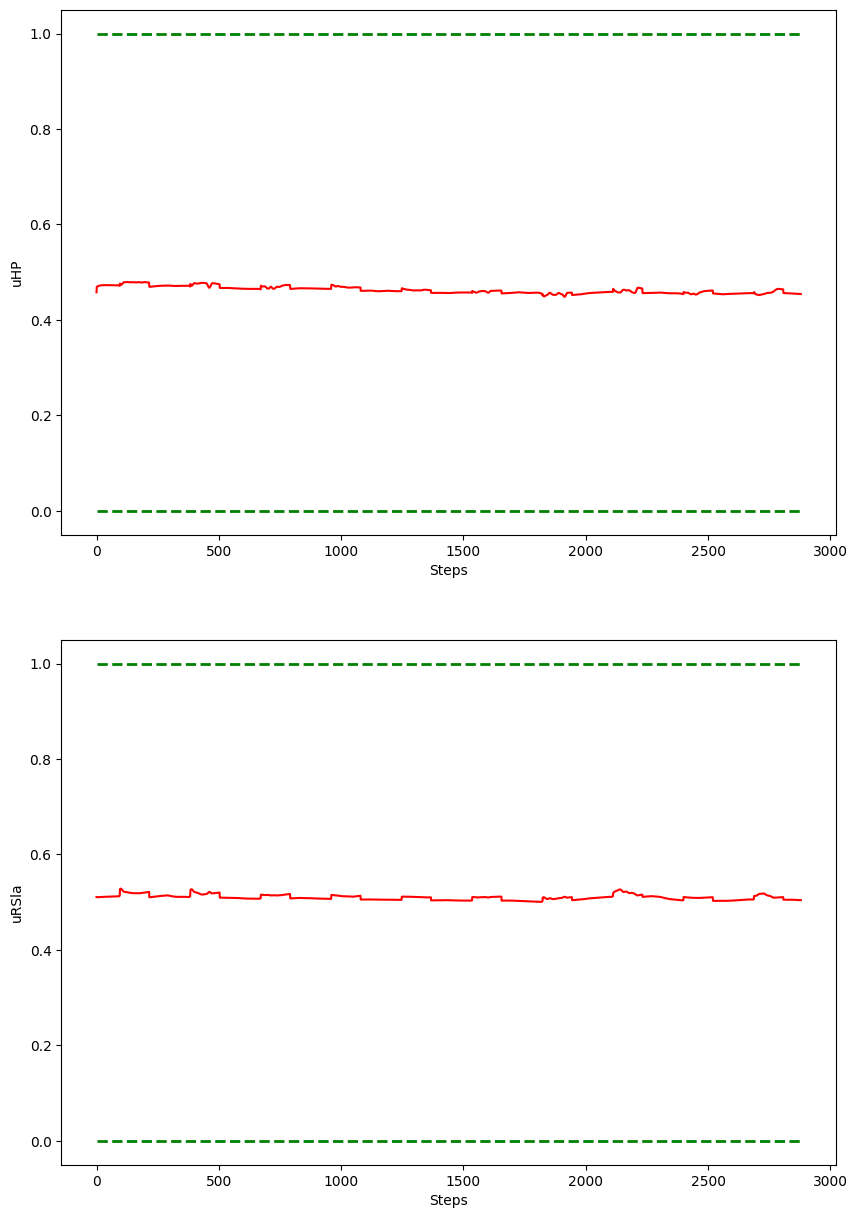

In [5]:
f, axs = plt.subplots(len(inputs),figsize=(10,15))#
for i, col in enumerate(inputs):
    axs[i].plot([x[0] for x in cmd_df[col]], 'r')
    axs[i].set_ylabel(col)
    axs[i].set_xlabel('Steps')
    if env_rl.env.input_specs[col]['type'] == 'scalar':
        intervals = [env_rl.env.input_specs[col]['lower_bound'], env_rl.env.input_specs[col]['upper_bound']]
    else: intervals = [0, 0]
    axs[i].plot([0, cmd_df.shape[0]], [intervals[0], intervals[0]], color='g', linestyle='--', linewidth=2)
    axs[i].plot([0, cmd_df.shape[0]], [intervals[1], intervals[1]], color='g', linestyle='--', linewidth=2)
    

In [3]:
# Building Name & State Dimensions & Control Dimensions & Num. of Constraints & Main Objective (Minimize) \\
from energym.wrappers.rl_wrapper import StableBaselinesRLWrapper
from buildings_factory import *
objectives = ["average exchanged energy",
              "average exchanged energy",
              "average exchanged energy",
              "average exchanged energy",
              "power demand",
              "power demand",
              "CO2 emission",
              "CO2 emission",
              "power demand",
              "power demand",
              "power demand",
              "power demand"]

model_info = ""
for building_name in buildings_list:
    # min_kpis, max_kpis = collect_baseline_kpi(building_name)
    building_idx = buildings_list.index(building_name)
    env = get_env(building_name)
    inputs = get_inputs(building_name, env)
    default_control = default_controls[building_idx]
    env_rl = StableBaselinesRLWrapper(building_name, None, None, reward_func)
    input_dim = env_rl.observation_space.shape[0]
    control_dim = env_rl.action_space.shape[0]
    constraint_num = 0
    for key, val in env.kpi_options.items():
        if val["type"] == 'avg_dev': constraint_num += 1 
    main_objective = objectives[building_idx]
    model_info += f"{building_name} & {input_dim} & {control_dim} & {constraint_num} & {main_objective} \\ "
print(model_info)

/home/lesong/energym/./energym/schedules/EVSchedule.py:60: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  self.schedule["Week"] = self.schedule["Time"].dt.week
/home/lesong/energym/./energym/schedules/EVSchedule.py:161: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  self.schedule.update(df_day)
/home/lesong/energym/./energym/schedules/EVSchedule.py:162: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  self.prediction.update(df_day_pred)


[OK] fmi2Instantiate: The Resource location of FMU with instance name instance1670729799 is file:///home/lesong/Energym_runs/1670729799_1301787/resources.

[WARNING] fmi2Instantiate: Argument loggingOn is set to 1
. This is not supported. loggingOn will default to '0'.

[OK] The current working directory is /home/lesong/energym

[OK] fmi2Instantiate: Path to fmuUnzipLocation ///home/lesong/Energym_runs/1670729799_1301787//

[OK] fmi2Instantiate: Path to fmuResourceLocation ///home/lesong/Energym_runs/1670729799_1301787//resources//

[OK] Command executes to copy content of resources folder: cp -f "///home/lesong/Energym_runs/1670729799_1301787//resources//"variables.cfg "/home/lesong/energym//Output_EPExport_instance1670729799//"

[OK] fmi2Instantiate: Path to model description file is ///home/lesong/Energym_runs/1670729799_1301787//modelDescription.xml.

[OK] fmi2Instantiate: The FMU modelIdentifier is Apartments_heavy_pump.

[OK] fmi2Instantiate: The FMU modelGUID is f6e98c8f74fafcd3

/home/lesong/energym/./energym/schedules/EVSchedule.py:177: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  indices = [self.schedule.index.get_loc(dt, method="nearest") for dt in dts]


Successfully finish reading weather file.
This is the Begin Month: 1
Time (0) set is smaller than minimun allowed (1 day). Day will be set to 1.
This is the Day of the Begin Month: 1
This is the End Month: 3
This is the Day of the End Month: 1
Day of week was left blank in input file.
This is the New Day of Week:  
[OK] This version uses the **energyplus** command line interface to  call the EnergyPlus executable. **RunEPlus.bat** and **runenergyplus** , which were used in earlier versions, were deprecated as of August 2015.
Running EPMacro...
ExpandObjects Started.
No expanded file generated.
ExpandObjects Finished. Time:     0.078
EnergyPlus Starting
EnergyPlus, Version 9.5.0-de239b2e5f, YMD=2022.12.11 03:36


Could not find platform independent libraries <prefix>
Could not find platform dependent libraries <exec_prefix>
Consider setting $PYTHONHOME to <prefix>[:<exec_prefix>]


Adjusting Air System Sizing
Adjusting Standard 62.1 Ventilation Sizing
Initializing Simulation
Reporting Surfaces
Beginning Primary Simulation
Initializing New Environment Parameters
Warming up {1}
Instantiating FunctionalMockupUnitExport interface
ExternalInterface initializes.
[OK] fmi2EnterInitializationMode: The connection has been accepted.

[OK] fmi2EnterInitializationMode: Slave instance1670729799 is initialized.

Number of outputs in ExternalInterface = 69
Number of inputs  in ExternalInterface = 13
Calculating Detailed Daylighting Factors, Start Date=01/01
Warming up {2}
Warming up {3}
Warming up {4}
Warming up {5}
Warming up {6}
Starting Simulation at 01/01/2017 for ALL_YEAR
ExternalInterface starts first data exchange.


/home/lesong/energym/./energym/schedules/EVSchedule.py:60: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  self.schedule["Week"] = self.schedule["Time"].dt.week
/home/lesong/energym/./energym/schedules/EVSchedule.py:161: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  self.schedule.update(df_day)
/home/lesong/energym/./energym/schedules/EVSchedule.py:162: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  self.prediction.update(df_day_pred)


[OK] fmi2Instantiate: The Resource location of FMU with instance name instance1670729817 is file:///home/lesong/Energym_runs/1670729817_1518312/resources.

[WARNING] fmi2Instantiate: Argument loggingOn is set to 1
. This is not supported. loggingOn will default to '0'.

[OK] The current working directory is /home/lesong/energym

[OK] fmi2Instantiate: Path to fmuUnzipLocation ///home/lesong/Energym_runs/1670729817_1518312//

[OK] fmi2Instantiate: Path to fmuResourceLocation ///home/lesong/Energym_runs/1670729817_1518312//resources//

[OK] Command executes to copy content of resources folder: cp -f "///home/lesong/Energym_runs/1670729817_1518312//resources//"variables.cfg "/home/lesong/energym//Output_EPExport_instance1670729817//"

[OK] fmi2Instantiate: Path to model description file is ///home/lesong/Energym_runs/1670729817_1518312//modelDescription.xml.

[OK] fmi2Instantiate: The FMU modelIdentifier is Apartments_heavy_pump.

[OK] fmi2Instantiate: The FMU modelGUID is f6e98c8f74fafcd3

/home/lesong/energym/./energym/schedules/EVSchedule.py:177: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  indices = [self.schedule.index.get_loc(dt, method="nearest") for dt in dts]


[OK] This version uses the **energyplus** command line interface to  call the EnergyPlus executable. **RunEPlus.bat** and **runenergyplus** , which were used in earlier versions, were deprecated as of August 2015.
Running EPMacro...
ExpandObjects Started.
No expanded file generated.
ExpandObjects Finished. Time:     0.078
EnergyPlus Starting
EnergyPlus, Version 9.5.0-de239b2e5f, YMD=2022.12.11 03:36


Could not find platform independent libraries <prefix>
Could not find platform dependent libraries <exec_prefix>
Consider setting $PYTHONHOME to <prefix>[:<exec_prefix>]


Adjusting Air System Sizing
Adjusting Standard 62.1 Ventilation Sizing
Initializing Simulation
Reporting Surfaces
Beginning Primary Simulation
Initializing New Environment Parameters
Warming up {1}
Instantiating FunctionalMockupUnitExport interface
ExternalInterface initializes.
[OK] fmi2EnterInitializationMode: The connection has been accepted.

[OK] fmi2EnterInitializationMode: Slave instance1670729817 is initialized.

Number of outputs in ExternalInterface = 69
Number of inputs  in ExternalInterface = 13
Calculating Detailed Daylighting Factors, Start Date=01/01
Warming up {2}
Warming up {3}
Warming up {4}
Warming up {5}
Warming up {6}
Starting Simulation at 01/01/2017 for ALL_YEAR
ExternalInterface starts first data exchange.


/home/lesong/energym/./energym/schedules/EVSchedule.py:60: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  self.schedule["Week"] = self.schedule["Time"].dt.week
/home/lesong/energym/./energym/schedules/EVSchedule.py:161: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  self.schedule.update(df_day)
/home/lesong/energym/./energym/schedules/EVSchedule.py:162: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  self.prediction.update(df_day_pred)


[OK] fmi2Instantiate: The Resource location of FMU with instance name instance1670729832 is file:///home/lesong/Energym_runs/1670729832_1897226/resources.

[WARNING] fmi2Instantiate: Argument loggingOn is set to 1
. This is not supported. loggingOn will default to '0'.

[OK] The current working directory is /home/lesong/energym

[OK] fmi2Instantiate: Path to fmuUnzipLocation ///home/lesong/Energym_runs/1670729832_1897226//

[OK] fmi2Instantiate: Path to fmuResourceLocation ///home/lesong/Energym_runs/1670729832_1897226//resources//

[OK] Command executes to copy content of resources folder: cp -f "///home/lesong/Energym_runs/1670729832_1897226//resources//"variables.cfg "/home/lesong/energym//Output_EPExport_instance1670729832//"

[OK] fmi2Instantiate: Path to model description file is ///home/lesong/Energym_runs/1670729832_1897226//modelDescription.xml.

[OK] fmi2Instantiate: The FMU modelIdentifier is Apartments_heavy_th.

[OK] fmi2Instantiate: The FMU modelGUID is 19ca37e9e920862428

/home/lesong/energym/./energym/schedules/EVSchedule.py:177: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  indices = [self.schedule.index.get_loc(dt, method="nearest") for dt in dts]


Successfully finish reading weather file.
This is the Begin Month: 1
Time (0) set is smaller than minimun allowed (1 day). Day will be set to 1.
This is the Day of the Begin Month: 1
This is the End Month: 3
This is the Day of the End Month: 1
Day of week was left blank in input file.
This is the New Day of Week:  
[OK] This version uses the **energyplus** command line interface to  call the EnergyPlus executable. **RunEPlus.bat** and **runenergyplus** , which were used in earlier versions, were deprecated as of August 2015.
Running EPMacro...
ExpandObjects Started.
No expanded file generated.
ExpandObjects Finished. Time:     0.078
EnergyPlus Starting
EnergyPlus, Version 9.5.0-de239b2e5f, YMD=2022.12.11 03:37


Could not find platform independent libraries <prefix>
Could not find platform dependent libraries <exec_prefix>
Consider setting $PYTHONHOME to <prefix>[:<exec_prefix>]


Adjusting Air System Sizing
Adjusting Standard 62.1 Ventilation Sizing
Initializing Simulation
Reporting Surfaces
Beginning Primary Simulation
Initializing New Environment Parameters
Warming up {1}
Instantiating FunctionalMockupUnitExport interface
ExternalInterface initializes.
[OK] fmi2EnterInitializationMode: The connection has been accepted.

[OK] fmi2EnterInitializationMode: Slave instance1670729832 is initialized.

Number of outputs in ExternalInterface = 69
Number of inputs  in ExternalInterface = 12
Calculating Detailed Daylighting Factors, Start Date=01/01
Warming up {2}
Warming up {3}
Warming up {4}
Warming up {5}
Warming up {6}
Starting Simulation at 01/01/2017 for ALL_YEAR
ExternalInterface starts first data exchange.


/home/lesong/energym/./energym/schedules/EVSchedule.py:60: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  self.schedule["Week"] = self.schedule["Time"].dt.week
/home/lesong/energym/./energym/schedules/EVSchedule.py:161: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  self.schedule.update(df_day)
/home/lesong/energym/./energym/schedules/EVSchedule.py:162: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  self.prediction.update(df_day_pred)


[OK] fmi2Instantiate: The Resource location of FMU with instance name instance1670729847 is file:///home/lesong/Energym_runs/1670729847_2303989/resources.

[WARNING] fmi2Instantiate: Argument loggingOn is set to 1
. This is not supported. loggingOn will default to '0'.

[OK] The current working directory is /home/lesong/energym

[OK] fmi2Instantiate: Path to fmuUnzipLocation ///home/lesong/Energym_runs/1670729847_2303989//

[OK] fmi2Instantiate: Path to fmuResourceLocation ///home/lesong/Energym_runs/1670729847_2303989//resources//

[OK] Command executes to copy content of resources folder: cp -f "///home/lesong/Energym_runs/1670729847_2303989//resources//"variables.cfg "/home/lesong/energym//Output_EPExport_instance1670729847//"

[OK] fmi2Instantiate: Path to model description file is ///home/lesong/Energym_runs/1670729847_2303989//modelDescription.xml.

[OK] fmi2Instantiate: The FMU modelIdentifier is Apartments_heavy_th.

[OK] fmi2Instantiate: The FMU modelGUID is 19ca37e9e920862428

/home/lesong/energym/./energym/schedules/EVSchedule.py:177: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  indices = [self.schedule.index.get_loc(dt, method="nearest") for dt in dts]


Successfully finish reading weather file.
This is the Begin Month: 1
Time (0) set is smaller than minimun allowed (1 day). Day will be set to 1.
This is the Day of the Begin Month: 1
This is the End Month: 3
This is the Day of the End Month: 1
Day of week was left blank in input file.
This is the New Day of Week:  
[OK] This version uses the **energyplus** command line interface to  call the EnergyPlus executable. **RunEPlus.bat** and **runenergyplus** , which were used in earlier versions, were deprecated as of August 2015.
Running EPMacro...
ExpandObjects Started.
No expanded file generated.
ExpandObjects Finished. Time:     0.078
EnergyPlus Starting
EnergyPlus, Version 9.5.0-de239b2e5f, YMD=2022.12.11 03:37


Could not find platform independent libraries <prefix>
Could not find platform dependent libraries <exec_prefix>
Consider setting $PYTHONHOME to <prefix>[:<exec_prefix>]


Adjusting Air System Sizing
Adjusting Standard 62.1 Ventilation Sizing
Initializing Simulation
Reporting Surfaces
Beginning Primary Simulation
Initializing New Environment Parameters
Warming up {1}
Instantiating FunctionalMockupUnitExport interface
ExternalInterface initializes.
[OK] fmi2EnterInitializationMode: The connection has been accepted.

[OK] fmi2EnterInitializationMode: Slave instance1670729847 is initialized.

Number of outputs in ExternalInterface = 69
Number of inputs  in ExternalInterface = 12
Calculating Detailed Daylighting Factors, Start Date=01/01
Warming up {2}
Warming up {3}
Warming up {4}
Warming up {5}
Warming up {6}
Starting Simulation at 01/01/2017 for ALL_YEAR
ExternalInterface starts first data exchange.


/home/lesong/energym/./energym/schedules/EVSchedule.py:60: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  self.schedule["Week"] = self.schedule["Time"].dt.week
/home/lesong/energym/./energym/schedules/EVSchedule.py:161: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  self.schedule.update(df_day)
/home/lesong/energym/./energym/schedules/EVSchedule.py:162: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  self.prediction.update(df_day_pred)
/home/lesong/energym/./energym/schedul

[OK] fmi2Instantiate: The Resource location of FMU with instance name instance1670729869 is file:///home/lesong/Energym_runs/1670729869_8898127/resources.

[WARNING] fmi2Instantiate: Argument loggingOn is set to 1
. This is not supported. loggingOn will default to '0'.

[OK] The current working directory is /home/lesong/energym

[OK] fmi2Instantiate: Path to fmuUnzipLocation ///home/lesong/Energym_runs/1670729869_8898127//

[OK] fmi2Instantiate: Path to fmuResourceLocation ///home/lesong/Energym_runs/1670729869_8898127//resources//

[OK] Command executes to copy content of resources folder: cp -f "///home/lesong/Energym_runs/1670729869_8898127//resources//"variables.cfg "/home/lesong/energym//Output_EPExport_instance1670729869//"

[OK] fmi2Instantiate: Path to model description file is ///home/lesong/Energym_runs/1670729869_8898127//modelDescription.xml.

[OK] fmi2Instantiate: The FMU modelIdentifier is Apartments2_heavy_insulated_pump.

[OK] fmi2Instantiate: The FMU modelGUID is 03582

/home/lesong/energym/./energym/schedules/EVSchedule.py:177: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  indices = [self.schedule.index.get_loc(dt, method="nearest") for dt in dts]


Successfully finish reading weather file.
This is the Begin Month: 1
Time (0) set is smaller than minimun allowed (1 day). Day will be set to 1.
This is the Day of the Begin Month: 1
This is the End Month: 3
This is the Day of the End Month: 1
Day of week was left blank in input file.
This is the New Day of Week:  
[OK] This version uses the **energyplus** command line interface to  call the EnergyPlus executable. **RunEPlus.bat** and **runenergyplus** , which were used in earlier versions, were deprecated as of August 2015.
Running EPMacro...


Exception ignored on calling ctypes callback function: <function printLogMessage at 0x7f114e5d3700>
Traceback (most recent call last):
  File "/anaconda/envs/env39/lib/python3.9/site-packages/fmpy/fmi1.py", line 84, in printLogMessage
    def printLogMessage(component, instanceName, status, category, message):
KeyboardInterrupt: 
Error: Called read from socket with negative socket number.
       sockfd : -1
Error: Called write to socket with negative socket number.
       sockfd : -1
Error: Called read from socket with negative socket number.
       sockfd : -1
/home/lesong/energym/./energym/schedules/EVSchedule.py:60: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  self.schedule["Week"] = self.schedule["Time"].dt.week
/home/lesong/energym/./energym/schedules/EVSchedule.py:161: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a ne

[OK] fmi2EnterInitializationMode: Slave instance1670729869 is initialized.

ExpandObjects Started.
No expanded file generated.
ExpandObjects Finished. Time:     0.170
EnergyPlus Starting
EnergyPlus, Version 9.5.0-de239b2e5f, YMD=2022.12.11 03:37


Could not find platform independent libraries <prefix>
Could not find platform dependent libraries <exec_prefix>
Consider setting $PYTHONHOME to <prefix>[:<exec_prefix>]


Adjusting Air System Sizing
Adjusting Standard 62.1 Ventilation Sizing
Initializing Simulation
Reporting Surfaces
Beginning Primary Simulation
Initializing New Environment Parameters
Warming up {1}
Instantiating FunctionalMockupUnitExport interface
ExternalInterface initializes.
Number of outputs in ExternalInterface = 68
Number of inputs  in ExternalInterface = 13
Calculating Detailed Daylighting Factors, Start Date=01/01
Warming up {2}
Warming up {3}
Warming up {4}
Warming up {5}
Warming up {6}
Starting Simulation at 01/01/2017 for ALL_YEAR
ExternalInterface starts first data exchange.


/home/lesong/energym/./energym/schedules/EVSchedule.py:60: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  self.schedule["Week"] = self.schedule["Time"].dt.week
/home/lesong/energym/./energym/schedules/EVSchedule.py:161: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  self.schedule.update(df_day)
/home/lesong/energym/./energym/schedules/EVSchedule.py:162: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  self.prediction.update(df_day_pred)


In [3]:
import pandas as pd
# buildings_list = ["ApartmentsThermal-v0", "ApartmentsGrid-v0", "Apartments2Thermal-v0",
#                   "Apartments2Grid-v0", "OfficesThermostat-v0", "MixedUseFanFCU-v0",
#                   "SeminarcenterThermostat-v0", "SeminarcenterFull-v0", "SimpleHouseRad-v0",
#                   "SimpleHouseRSla-v0", "SwissHouseRSlaW2W-v0", "SwissHouseRSlaTank-v0"] 

plot_building_names = ["SwissHouseRSlaW2W-v0", "SwissHouseRSlaTank-v0"]
seeds = [7, 13, 19, 23]
# model_names = ["manual_simulator", "manual_predictor", "rewards_simulator", "rewards_predictor"]
# legend_names = ["Real Env. with Manual Reward Func.", "Learnt Env. with Manual Reward Func.",
#                 "Real Env. with Learnt Reward Func.", "Learnt Env. with Learnt Reward Func."]
model_names = ["manual_predictor", "rewards_predictor"]
legend_names = ["Learnt Env. with Manual Reward Func.",
                "Learnt Env. with Learnt Reward Func."]
# res_cols = ["manual_baseline_eval_episode_reward", "manual_eval_episode_reward",
#             "baseline_eval_episode_reward", "eval_episode_reward"]
res_cols = ["manual_baseline_eval_episode_reward", "manual_eval_episode_reward"]
            
colors = ['r', 'g', 'r--', 'g--']

res_data = []
for seed in seeds:
    for model_name, legend_name in zip(model_names, legend_names):
        for building in plot_building_names:
            res_loc = f"data/models/{building}/{model_name}_seed{seed}/logs/best/rewards.csv"
            res_row = pd.read_csv(res_loc).iloc[-1, :]
            res_data.append([seed, building, model_name, legend_name,
                             res_row["eval_episode_reward"], res_row["manual_eval_episode_reward"],
                             res_row["baseline_eval_episode_reward"], res_row["manual_baseline_eval_episode_reward"]])
res_df = pd.DataFrame(res_data, columns=["seed", "building", "model_name", 
                                         "legend", "learnt_reward", "manual_reward",
                                         "learnt_baseline_reward", "manual_baseline_reward"])
            

res_df.head()

,seed,building,model_name,legend,learnt_reward,manual_reward,learnt_baseline_reward,manual_baseline_reward
0,7,SwissHouseRSlaW2W-v0,manual_predictor,Learnt Env. with Manual Reward Func.,11324.373899,11324.373899,-64380.044022,-64380.044022
1,7,SwissHouseRSlaTank-v0,manual_predictor,Learnt Env. with Manual Reward Func.,2193.330649,2193.330649,-71312.633945,-71312.633945
2,7,SwissHouseRSlaW2W-v0,rewards_predictor,Learnt Env. with Learnt Reward Func.,172790.000000,10876.956944,113982.434537,-64380.044022
3,7,SwissHouseRSlaTank-v0,rewards_predictor,Learnt Env. with Learnt Reward Func.,159348.512635,4476.764377,40391.214919,-71312.633945
4,13,SwissHouseRSlaW2W-v0,manual_predictor,Learnt Env. with Manual Reward Func.,9144.573254,9144.573254,-64380.044022,-64380.044022


In [4]:
import numpy as np
cols = res_df.columns.tolist()
# "RL_reward", "manual_RL_reward", "baseline_reward", "manual_baseline_reward"
cols.remove("seed")
stat_df = res_df[cols].groupby(["building", "model_name", "legend"]).agg(learnt_reward_mean=("learnt_reward", np.mean),
                                                           learnt_reward_std=("learnt_reward", np.std),
                                                           learnt_baseline_reward_mean=("learnt_baseline_reward", np.mean),
                                                           learnt_baseline_reward_std=("learnt_baseline_reward", np.std),
                                                           manual_reward_mean=("manual_reward", np.mean),
                                                           manual_reward_std=("manual_reward", np.std),
                                                           manual_baseline_reward_mean=("manual_baseline_reward", np.mean),
                                                           manual_baseline_reward_std=("manual_baseline_reward", np.std)).reset_index()

stat_df

,building,model_name,legend,learnt_reward_mean,learnt_reward_std,learnt_baseline_reward_mean,learnt_baseline_reward_std,manual_reward_mean,manual_reward_std,manual_baseline_reward_mean,manual_baseline_reward_std
0,SwissHouseRSlaTank-v0,manual_predictor,Learnt Env. with Manual Reward Func.,7512.659637,4302.133534,-71312.633945,0.0,7512.659637,4302.133534,-71312.633945,0.0
1,SwissHouseRSlaTank-v0,rewards_predictor,Learnt Env. with Learnt Reward Func.,132252.542864,71452.216069,40391.214919,0.0,-18786.959932,55436.609443,-71312.633945,0.0
2,SwissHouseRSlaW2W-v0,manual_predictor,Learnt Env. with Manual Reward Func.,9569.144690,1724.463536,-64380.044022,0.0,9569.144690,1724.463536,-64380.044022,0.0
3,SwissHouseRSlaW2W-v0,rewards_predictor,Learnt Env. with Learnt Reward Func.,172789.679952,0.640096,113982.434537,0.0,10263.491105,1903.986617,-64380.044022,0.0


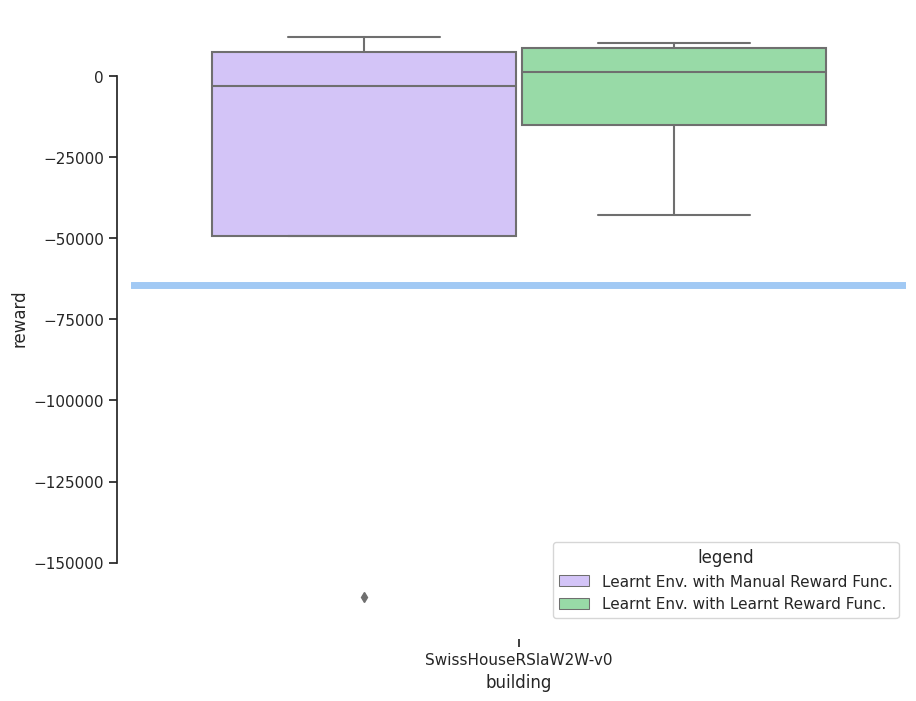

In [ ]:
import seaborn as sns
from matplotlib import pyplot as plt
sns.set_theme(style="ticks", palette="pastel")
fig, ax = plt.subplots(figsize=(10, 8))

# Load the example tips dataset
baseline_reward = res_df.loc[res_df["algorithm"]=="baseline", "reward"].mean()
res_df_rl = res_df.loc[res_df["algorithm"]=="RL", :]
# Draw a nested boxplot to show bills by day and time
fig = sns.boxplot(ax=ax, x="building", y="reward",
            hue="legend", palette=["m", "g", 'r', 'b'],
            data=res_df_rl)
fig.axhline(baseline_reward, linewidth=5.0, label="baseline")
sns.despine(offset=10, trim=True)